# Galaxy-Galaxy Lensing

in this notebook we show how to use `glasz` to compute $\Delta \Sigma$ given a halo profile. This is really just a wrapper of a few functions from the `pyccl.halos` package which can be found [here](https://ccl.readthedocs.io/en/latest/api/pyccl.halos.profiles.profile_base.html).

In [3]:
# preamble
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
from init_halo_model import (  # halo model
    a_arr,
    bM,
    cM_relation,
    cosmo,
    hmc,
    hmd,
    k_arr,
    r_arr,
)

import glasz

# CMASS PARAMETERS
z_lens = 0.55  # Mean z for CMASS
a_sf = 1 / (1 + z_lens)

# constituent fractions
fb = cosmo["Omega_b"] / cosmo["Omega_m"]  # Baryon fraction
fc = cosmo["Omega_c"] / cosmo["Omega_m"]  # CDM fraction

# define 2-halo term
xi_mm_2h = glasz.profiles.calc_xi_mm_2h(
    cosmo, hmd, cM_relation, hmc, k_arr, a_arr, r_arr, a_sf
)

We can simply use the `glasz.GGL` subpackage to compute $\Delta \Sigma$ from an NFW profile. To speed up calculation, we make sure to turn on `fourier_analytic` which will compute the Fourier transform of the NFW profile analytically. The underlying functions used to compute $\Delta \Sigma$ rely on the `pyccl` implementation of the `fftlog` algorithm which is blazingly fast.

We note a subtlety here, the `pyccl` profiles and `glasz.GGL` functions assume comoving units without factors of $h$. If we want to match the observations of [Amon & Robertson et al. 2022](https://arxiv.org/pdf/2202.07440), we need to properly account for this.

In [35]:
M_halo = 3e13  # solar masses
R = np.geomspace(
    1e-2, 6e1, 100
)  # Mpc/h comoving units (like observations of Amon & Robertson et al. 2022)

prof_nfw = ccl.halos.HaloProfileNFW(
    mass_def=hmd,
    concentration=cM_relation,
    truncated=False,
    cumul2d_analytic=True,
    projected_analytic=True,
    fourier_analytic=True,
)

ds_nfw = (
    glasz.GGL.calc_ds(
        cosmo,
        R / cosmo["h"],  # convert from Mpc/h to Mpc
        M_halo,
        a_sf,
        prof_nfw,
    )
    / cosmo["h"]
)  # convert from Msun/pc^2 to h Msun/pc^2

We can plot it!

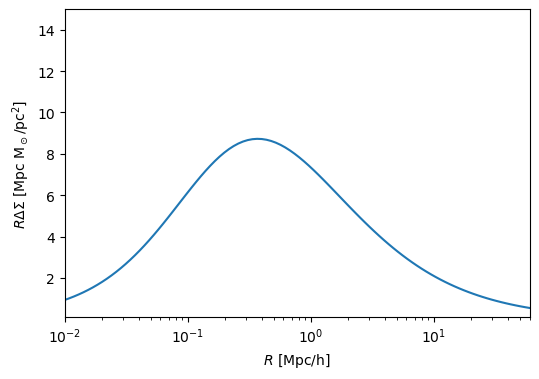

In [36]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogx(R, ds_nfw * R)
ax.set_xlabel(r"$R$ [Mpc/h]")
ax.set_ylabel(r"$R \Delta\Sigma$ [Mpc M$_\odot$/pc$^2$]")
ax.set_ylim(0.1, 15)
ax.set_xlim(1e-2, 6e1)
plt.show()

We designed `glasz.GGL` to take in any `pyccl` halo profile, one can see this in action below. For more details of what is happening with the creation of these profiles, visit the `profiles` notebook in the documentation.

In [37]:
# Halo Mass
M_halo = 3e13

# 2-halo Amplitude
A_2h = 0.7

# GNFW Parameters
alpha = 1.0
beta = 3.0
gamma = 0.2
x_c = 0.5

Rb = 10 * (hmd.get_radius(cosmo, M_halo, a_sf) / a_sf)

# COMPUTE GNFW AMPLITUDE
prof_nfw = ccl.halos.HaloProfileNFW(
    mass_def=hmd, concentration=cM_relation, truncated=False, fourier_analytic=True
)

prof_baryons = glasz.profiles.HaloProfileGNFW(
    hmd,
    rho0=1.0,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    x_c=x_c,
)

prof_baryons.normalize(cosmo, Rb, M_halo, a_sf, prof_nfw)


# COMPUTE 3D DENSITY PROFILES
def rho_2h(r):
    return (
        xi_mm_2h(r)
        * bM(cosmo, M_halo, a_sf)
        * ccl.rho_x(cosmo, a_sf, "matter", is_comoving=True)
        * A_2h
    )


prof_baryons.rho_2h = rho_2h  # add 2-halo term to baryon profile

prof_matter = glasz.profiles.MatterProfile(
    mass_def=hmd, concentration=cM_relation, rho_2h=rho_2h
)

Once the baryon and matter profiles have been created, we can feed them into `glasz.GGL.calc_ds` like the NFW profile from earlier.

In [38]:
# COMPUTE ΔΣ PROFILE
ds_b = (
    fb
    * glasz.GGL.calc_ds(
        cosmo,
        R / cosmo["h"],  # convert from Mpc/h to Mpc
        M_halo,
        a_sf,
        prof_baryons,
    )
    / cosmo["h"]
)  # convert from Msun/pc^2 to h Msun/pc^2


ds_dm = (
    fc
    * glasz.GGL.calc_ds(
        cosmo,
        R / cosmo["h"],  # convert from Mpc/h to Mpc
        M_halo,
        a_sf,
        prof_matter,
    )
    / cosmo["h"]
)  # convert from Msun/pc^2 to h Msun/pc^2

ds = ds_b + ds_dm

Now we can plot this example!

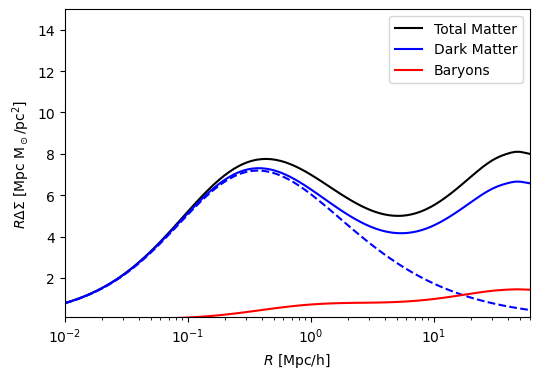

In [41]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.semilogx(R, ds * R, color="black", label="Total Matter")

ax.semilogx(R, ds_dm * R, ls="-", color="blue", label="Dark Matter")
ax.semilogx(R, fc * ds_nfw * R, ls="--", color="blue")

ax.semilogx(R, ds_b * R, ls="-", color="red", label="Baryons")

ax.set_xlabel(r"$R$ [Mpc/h]")
ax.set_ylabel(r"$R \Delta\Sigma$ [Mpc M$_\odot$/pc$^2$]")

ax.set_ylim(0.1, 15)
ax.set_xlim(1e-2, 6e1)
ax.legend()
plt.show()